# Introduction: Data Exploration

# Setup
Let us import the required modules.

In [1]:
%%time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

CPU times: user 222 ms, sys: 108 ms, total: 330 ms
Wall time: 687 ms


In [2]:
from src.utilities.utils import get_dataset_dir, has_files_in_dir
from src.utilities.dataset import  download_data, store_data, load_data
from src.models.model import Dataset

## Get Data

Fetch MINST dataset from given url and save it, or load dataset if already present.

In [3]:
if not has_files_in_dir(get_dataset_dir()):
    data = download_data()
    store_data(data=data, reduced=False)
else:
    data = load_data(reduced=False)

data

Loading /Users/a/GitHub/clustering/src/data/x_pixels.csv 
Loading /Users/a/GitHub/clustering/src/data/y_labels.csv 


[Length: 70000; Features: 784]

In [4]:
data.x.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 784 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel1    float64
 1    pixel2    float64
 2    pixel3    float64
 3    pixel4    float64
 4    pixel5    float64
 5    pixel6    float64
 6    pixel7    float64
 7    pixel8    float64
 8    pixel9    float64
 9    pixel10   float64
 10   pixel11   float64
 11   pixel12   float64
 12   pixel13   float64
 13   pixel14   float64
 14   pixel15   float64
 15   pixel16   float64
 16   pixel17   float64
 17   pixel18   float64
 18   pixel19   float64
 19   pixel20   float64
 20   pixel21   float64
 21   pixel22   float64
 22   pixel23   float64
 23   pixel24   float64
 24   pixel25   float64
 25   pixel26   float64
 26   pixel27   float64
 27   pixel28   float64
 28   pixel29   float64
 29   pixel30   float64
 30   pixel31   float64
 31   pixel32   float64
 32   pixel33   float64
 33   pixel34   float64
 34   pixel35   float64
 3

In [5]:
data.y

array([5, 0, 4, ..., 4, 5, 6])

## Digit distribution

<Axes: ylabel='count'>

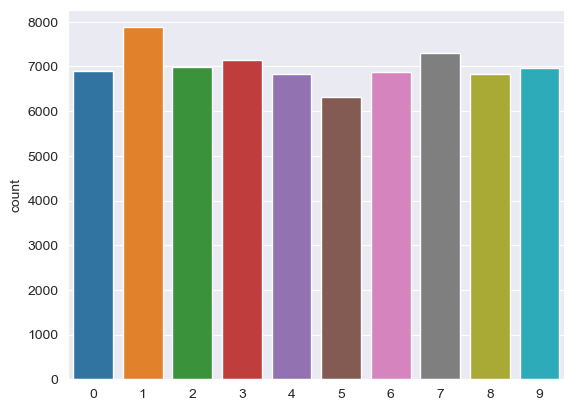

In [6]:
sns.countplot(x=data.y)

## Visualization

In [7]:
def plot_data(data, rows=3, cols=5):
    """
    Plot the first rows*cols digits of the dataset
    :param data:
    :param rows:
    :param cols:
    :return:
    """
    to_plot = data.x[:rows*cols].to_numpy().reshape(rows*cols,28,28)
    fig, axs = plt.subplots(rows, cols)
    k = 0

    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(to_plot[k], cmap=plt.get_cmap('gray'))
            axs[i,j].axis('off')
            k += 1

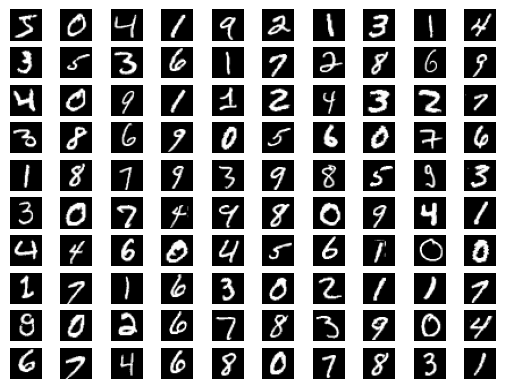

In [8]:
plot_data(data, 10, 10)

In [9]:
def plot_digits(data: Dataset):
    """
    Plot digits in a 2-dimensional space using Principal Component Analysis (PCA)
    :param data: dataset
    """
    colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray', 'cyan']

    # get two principal components using PCA
    pca2_x, pca2_y = data.make_pca(n_comps=2).rescale()

    plt.figure(figsize=(8,8))
    plt.scatter(pca2_x.loc[:,0], pca2_x.loc[:,1], c=pca2_y, cmap=mplt.colors.ListedColormap(colors), alpha=0.7)

    color_bar = plt.colorbar()
    color_ticks = np.arange(0,max(pca2_y),max(pca2_y)/float(len(colors)))
    color_bar.set_ticks(color_ticks)
    color_bar.set_ticklabels([n for n in list(range(10))])

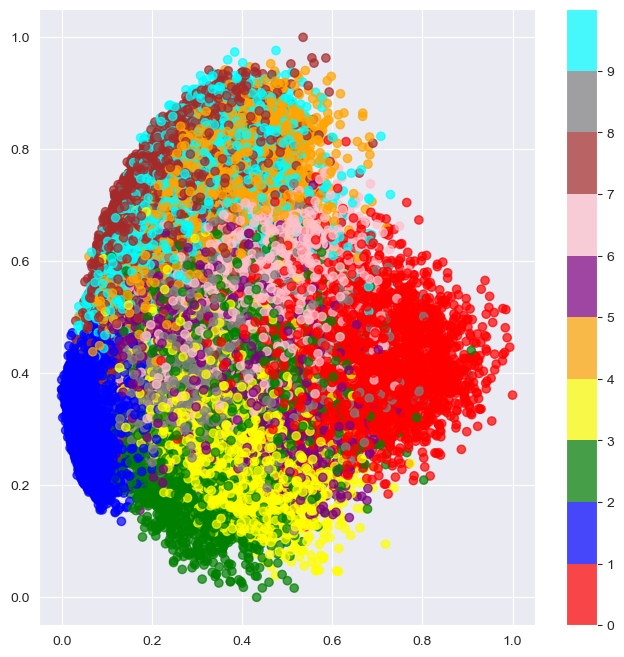

In [10]:
plot_digits(data=data)

## Reducing dataset size

In [11]:
random_seed = 28

def reduce_data(data: Dataset, percentage: float = 1.) -> Dataset:
    """
    Return a randomly reduced-percentage dataset
    return: new dataset
    """

    if not 0. <= percentage <= 1.:
        raise Exception(f"Percentage {percentage} not in range [0, 1] ")

    _,x,_,y = train_test_split(data.x, data.y, test_size=percentage)

    return Dataset(x, y)

In [12]:
reduced_data = reduce_data(data=data, percentage=0.20)
reduced_data

[Length: 14000; Features: 784]

<Axes: ylabel='count'>

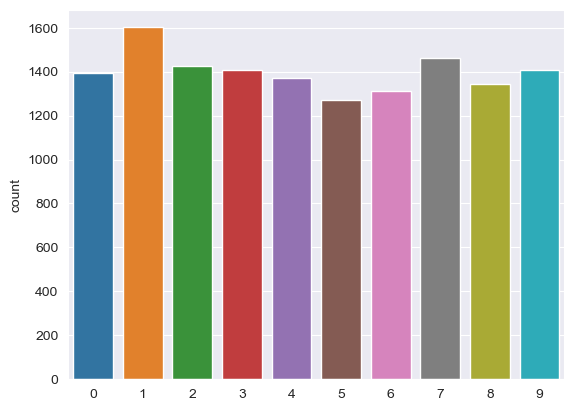

In [13]:
sns.countplot(x=reduced_data.y)

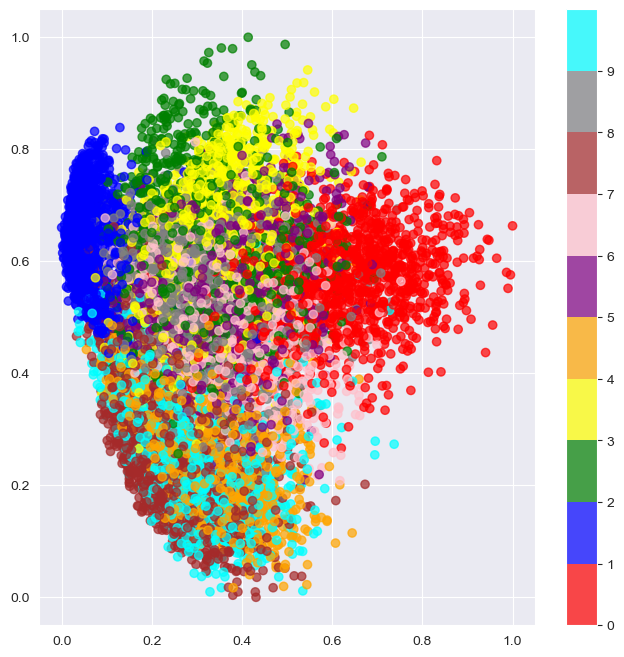

In [14]:
plot_digits(data=reduced_data)

In [15]:
store_data(data=reduced_data, reduced=True)

Storing MNIST. 
Saving /Users/a/GitHub/clustering/src/data/red_x_pixels.csv
Saving /Users/a/GitHub/clustering/src/data/red_y_labels.csv


PCA reduction
(TODO,
interesting but do i need to do it beforehand? its a quite fast calculation after all)

In [8]:
def PCA_dfs(max_pca_dim:int, percentage:float):
    """
    Function that:

    1) samples the initial dataset until the target "percentage" is reached.
    2) saves the sampled initial dataset to file.
    3) generates a set of PCA reduced datasets from 2 PCA dimensions to "max_pca_dim".
    4) save each reduced dataset to file (folder /dataset/) along with the PCA object (pca).

    Args:
        max_pca_dim (int): max PCA dimension to reach when generating the set of datasets.
        percentage (float): target percentage to reach when sampling the initial dataset.
    """

    #random state to ensure replicability
    r=np.random.RandomState(32)

    #index sampling
    indexes=r.choice(70000,int(70000*percentage),replace=False)

    #save sampled dataset to file
    X.iloc[indexes].to_parquet("dataset/X.parquet")
    y[indexes].to_frame().to_parquet("dataset/y.parquet")

    for i in tqdm(range(2,max_pca_dim+1,10)):

        #PCA object with target number of dimensions
        pca=PCA(n_components=i)

        #PCA reduced dataset for i target dimensions
        df=pd.DataFrame(pca.fit_transform(X),columns=["PC_"+str(x) for x in range(1,i+1)])

        #sample the same indexes as the initial dataset
        df=df.iloc[indexes]

        #save reduced dataset to file
        df.to_parquet("dataset/PCA_"+str(i)+".parquet")

        #save PCA object to file
        with open("pca/pca_"+str(i)+".pkl", 'wb') as out:
            pickle.dump(pca, out, pickle.HIGHEST_PROTOCOL)

PCA_dfs(200,0.5)

  0%|          | 0/20 [00:00<?, ?it/s]